### Imports

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

pd.options.display.max_rows = 4000
pd.options.display.max_columns = 100

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor

import pickle 


### Reading in Data

In [25]:
# read in data 
train_data = pd.read_csv("data/train.csv", encoding='ISO-8859-1')
test_data = pd.read_csv("data/test.csv", encoding='ISO-8859-1')
y_test = pd.read_csv("data/test_salaries.csv", encoding='ISO-8859-1')


train_data = train_data.rename(columns = {"+/-": "plusMinus"})
test_data = test_data.rename(columns = {"+/-": "plusMinus"})


### Preprocessing + Feature Selection

In [26]:
# hand-selecting a small subset of features for model demo-ing purposes
target = ["Salary"]
id_features = ["First Name", "Last Name" , "Team"]
model_features = [
    "plusMinus", 
    "Position",
    "G",
    "A1",
    "GP",
    "Grit",
    "TOI%",
    "xGA",
    "xGF"
]
print(f"unique positions in dataset: {train_data.Position.unique()}")

unique positions in dataset: ['D' 'RW' 'LW/C' 'RW/C/LW' 'C' 'C/RW' 'LW' 'RW/LW' 'C/LW/RW' 'LW/RW'
 'C/LW' 'LW/C/RW' 'LW/RW/C' 'RW/C' 'C/RW/LW' 'RW/LW/C' 'D/LW' 'C/D']


In [27]:
# a player can have multiple positions, only keeping their first positon listed
train_data['Position'] = train_data['Position'].str.split("/", expand=True)[0]
test_data['Position'] = test_data['Position'].str.split("/", expand=True)[0]

print(f"unique positions in dataset: {train_data.Position.unique()}")

unique positions in dataset: ['D' 'RW' 'LW' 'C']


In [28]:
# checking for nulls before fitting RF model
train_data[id_features + model_features + target].isnull().mean()

First Name    0.000000
Last Name     0.000000
Team          0.000000
plusMinus     0.000000
Position      0.000000
G             0.000000
A1            0.000000
GP            0.000000
Grit          0.000000
TOI%          0.001634
xGA           0.001634
xGF           0.001634
Salary        0.000000
dtype: float64

In [29]:
# since only 3 observations have nulls, and it is a very small % of rows, simply dropping these rows from the data
model_data = train_data.dropna(subset=model_features)
model_data = model_data[id_features + model_features + target]

print(model_data.shape)
model_data.sample(5)

(611, 13)


,First Name,Last Name,Team,plusMinus,Position,G,A1,GP,Grit,TOI%,xGA,xGF,Salary
446,Ben,Thomson,N.J,-4,LW,0,0,3,12,20.0,1.4,1.9,635000
148,Vladimir,Tarasenko,STL,-1,RW,39,18,82,93,31.8,52.8,80.2,8000000
341,Evan,McEneny,VAN,-1,D,0,0,1,0,27.3,0.7,0.6,575000
108,Valentin,Zykov,CAR,1,LW,1,0,2,0,13.0,0.5,1.3,727500
552,Joshua,Ho-Sang,NYI,1,RW,4,5,21,18,29.2,14.8,17.7,925000


### Model Fitting

In [30]:
# creating sklearn pipeline for quick data transformation and model fitting
clf = RandomForestRegressor()
categorical_columns = ['Position']
ct = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown='ignore'), categorical_columns)], remainder="passthrough"
)
pipe = Pipeline([
    ("categorical_encode", ct),
    ("clf", clf)
])

In [31]:
# split into train/test
X = model_data[model_features]
y = model_data[target]

y_preds = pipe.fit(X, y).predict(test_data[model_features])

/opt/anaconda3/envs/.flask-ml-cloud-serverless-demo/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Model Evaluation

In [92]:
# printing out standard regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = [
    ("MSE", mean_squared_error(y_test, y_preds)),
    # ("RMSE", root_mean_squared_error),
    ("MAE", mean_absolute_error(y_test, y_preds)),
    ("R2", r2_score(y_test, y_preds))
]

for metric in metrics:
    print(f"{metric[0]}: {metric}")

MSE: 3356430247828.6562
MAE: 1153586.503816794
R2: 0.4318743081364447


<Axes: xlabel='Salary'>

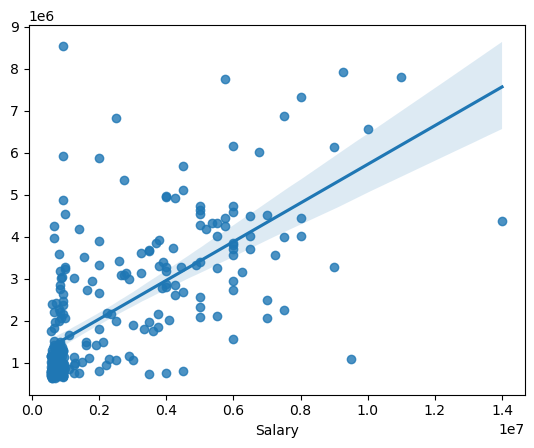

In [99]:
sns.regplot(y=y_preds, x=y_test)

### Saving Final Model

In [33]:
recs = {
    "plusMinus": {
        "0": -4,
        "1": -7,
        "2": 0,
        "3": 13,
        "4": -27,
        "5": -2,
        "6": -11,
        "7": 0,
        "8": -20,
        "9": 27
    },
    "Position": {
        "0": "D",
        "1": "LW",
        "2": "D",
        "3": "LW",
        "4": "C",
        "5": "RW",
        "6": "C",
        "7": "C",
        "8": "D",
        "9": "C"
    },
    "G": {
        "0": 0,
        "1": 2,
        "2": 0,
        "3": 27,
        "4": 15,
        "5": 0,
        "6": 17,
        "7": 0,
        "8": 14,
        "9": 30
    },
    "A1": {
        "0": 1,
        "1": 1,
        "2": 0,
        "3": 9,
        "4": 13,
        "5": 0,
        "6": 23,
        "7": 0,
        "8": 14,
        "9": 44
    },
    "GP": {
        "0": 36,
        "1": 20,
        "2": 1,
        "3": 81,
        "4": 82,
        "5": 7,
        "6": 79,
        "7": 4,
        "8": 72,
        "9": 82
    },
    "Grit": {
        "0": 139,
        "1": 13,
        "2": 2,
        "3": 316,
        "4": 54,
        "5": 9,
        "6": 69,
        "7": 0,
        "8": 199,
        "9": 89
    },
    "TOI%": {
        "0": 23.8,
        "1": 24.6,
        "2": 35.8,
        "3": 30.0,
        "4": 32.3,
        "5": 17.4,
        "6": 30.3,
        "7": 17.4,
        "8": 39.3,
        "9": 35.3
    },
    "xGA": {
        "0": 24.3,
        "1": 10.3,
        "2": 1.1,
        "3": 53.2,
        "4": 58.3,
        "5": 2.2,
        "6": 46.2,
        "7": 1.5,
        "8": 65.2,
        "9": 69.7
    },
    "xGF": {
        "0": 16.7,
        "1": 11.9,
        "2": 0.3,
        "3": 82.0,
        "4": 69.5,
        "5": 4.1,
        "6": 81.0,
        "7": 1.1,
        "8": 76.9,
        "9": 115.7
    },
    "First Name": {
        "0": "Alex",
        "1": "Kyle",
        "2": "Chris",
        "3": "Patrick",
        "4": "Henrik",
        "5": "Nicklas",
        "6": "Sam",
        "7": "Chandler",
        "8": "Mike",
        "9": "Connor"
    },
    "Last Name": {
        "0": "Biega",
        "1": "Connor",
        "2": "Butler",
        "3": "Maroon",
        "4": "Sedin",
        "5": "Jensen",
        "6": "Reinhart",
        "7": "Stephenson",
        "8": "Green",
        "9": "McDavid"
    },
    "Team": {
        "0": "VAN",
        "1": "WPG",
        "2": "STL",
        "3": "EDM",
        "4": "VAN",
        "5": "NYR",
        "6": "BUF",
        "7": "WSH",
        "8": "DET",
        "9": "EDM"
    }
}

dict

In [34]:
prediction_sample = pd.DataFrame(recs)

In [36]:
with open("simple_pipeline_clf.pkl", "rb") as f:
    loaded_pipe = pickle.load(f)

preds = loaded_pipe.predict(prediction_sample)

In [42]:
import json 

list(train_data['Team'])


['OTT',
 'OTT',
 'BUF',
 'VAN',
 'WSH',
 'CHI',
 'VAN',
 'BUF',
 'N.J',
 'T.B',
 'CHI',
 'VAN',
 'ARI/MIN',
 'CGY',
 'FLA',
 'CGY',
 'PIT',
 'EDM/NYR',
 'TOR',
 'N.J',
 'TOR',
 'STL',
 'TOR',
 'T.B',
 'BOS',
 'BOS',
 'COL',
 'STL',
 'PIT',
 'BOS',
 'PHI',
 'CAR',
 'ANA/VAN',
 'MTL',
 'PHI',
 'COL',
 'NSH',
 'CAR',
 'DAL/MTL',
 'T.B',
 'EDM',
 'L.A',
 'DAL',
 'DET',
 'MTL',
 'CBJ',
 'ANA',
 'TOR',
 'PHI',
 'ARI',
 'CAR',
 'PHI',
 'CAR',
 'MIN',
 'BOS',
 'MIN',
 'COL',
 'EDM',
 'NYI',
 'BUF',
 'DAL',
 'CBJ',
 'NYI',
 'CHI',
 'EDM',
 'MIN',
 'OTT',
 'VAN',
 'CGY',
 'S.J',
 'WPG',
 'ANA',
 'S.J',
 'VAN',
 'L.A/MTL',
 'MTL',
 'WSH',
 'NSH',
 'L.A',
 'ARI',
 'DET',
 'WSH',
 'N.J',
 'WSH',
 'T.B',
 'DET',
 'PHI',
 'CHI',
 'N.J/NSH/VAN',
 'ARI',
 'ANA',
 'FLA',
 'ANA',
 'CGY',
 'CBJ',
 'CBJ',
 'OTT',
 'N.J',
 'MTL',
 'WPG',
 'VAN',
 'COL',
 'CHI',
 'CHI',
 'FLA',
 'L.A',
 'S.J',
 'CGY',
 'CAR',
 'CAR',
 'ARI',
 'N.J',
 'PHI',
 'S.J',
 'TOR',
 'L.A',
 'BUF',
 'WPG',
 'NYI',
 'MIN',
 'MIN',
 'OT